# Análise de Inadimplência e Score para Prospects

Este notebook tem como objetivo

1. Desenvolver um modelo preditivo para probabilidade de inadimplência usando a base de clientes
2. Aplicar o modelo de cliente na base prospects
3. Calcular o score para os prospects
4. Gerar arquivo final com score para prospects

### Importar bibliotecas necessárias

In [ ]:
# pipenv install pandas plotly matplotlib seaborn scipy ipykernel scikit-learn optuna colorama nbformat lightgbm
# EDA e Visualização de Dados

import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# Otimização
import optuna

# Utilitários
import joblib
import math

c:\Users\felipe.fardo\.virtualenvs\challenge-VkipJ5TK\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abrir Base Clientes

In [2]:
df_clients = pd.read_csv('./datasets/clients.csv')

In [3]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

### Visualizar primeiros e últimos registros

In [4]:
print('Primeiros registros:')
display(df_clients.head(10))

print('últimos registros:')
display(df_clients.tail(10))

Primeiros registros:


,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
0,bc3749c2-932f-462b-a71e-d1a352510f67,Nicole Lopes,32,5,4,2,4,5,3,1,2,4,Brasília,Engenheiro agrônomo,Divorciado,4,2,Próprio,True,34118,631262,55649,294254,0.00000,232,Rocketseat Mastercard Travel Elite
1,981dffc4-087e-4a99-bbac-062944f9b5a7,Kevin Teixeira,42,1,4,5,1,4,1,5,3,5,Campo Grande,Psicólogo,Divorciado,18,2,Alugado,True,7338,376417,1777324,180331,87.00000,27,Rocketseat Mastercard Life Basic
2,242f4e94-7f2a-4557-a27a-9227cca55e83,Augusto Sá,67,4,3,4,3,2,3,3,2,3,Goiânia,Intérprete de Bíblias,Solteiro,19,6,Alugado,True,19965,83667,1793731,122049,78.45000,57,Rocketseat Mastercard Travel Basic
3,e6f16b89-d9bf-4448-9d08-65957cdc1fb3,Ágatha Moura,47,2,3,1,2,1,3,4,3,1,Porto Alegre,Engenheiro de projetos,Divorciado,6,6,Próprio,False,25867,283060,1940685,335544,85.21000,32,Rocketseat Visa Travel Basic
4,79b7f5b0-e754-4cd9-9150-ed5913fef23a,João Rios,27,3,5,4,5,4,3,2,2,5,Fortaleza,Cantor,Solteiro,1,1,Alugado,True,18359,146413,517215,390588,89.12000,0,Rocketseat Visa Life Basic
5,c403b04d-6f51-4374-b367-1adce70cdafb,Juliana Sales,56,5,3,5,1,1,5,3,3,1,Curitiba,Tecelão,Viúvo,5,4,Alugado,False,5163,403457,800313,312417,82.44000,0,Rocketseat Mastercard Travel Basic
6,fd42f59f-18f3-428a-8e04-83263518946a,Sra. Brenda Almeida,50,5,5,2,2,3,2,5,5,1,Manaus,Babysitter,Divorciado,15,1,Alugado,False,7973,912804,1311349,156471,78.36000,74,Rocketseat Visa Travel Basic
7,e1a94ba9-8c52-4bc0-a7c5-6ea6ab430f6e,Lavínia Rios,33,1,4,1,5,2,2,4,5,2,Curitiba,Astronauta,Viúvo,6,5,Alugado,False,4796,252572,1841319,297458,93.47000,4,Rocketseat Visa Life Basic
8,bb3e64ba-c46b-4ce7-a915-a5ac5d25fb3e,Rhavi Rezende,60,1,2,2,1,3,1,5,5,2,Manaus,Ferramenteiro,Casado,0,1,Alugado,True,43590,391559,918762,471656,76.12000,43,Rocketseat Mastercard Travel Basic
9,11278877-2221-4c1c-842a-d8fe968f295e,Otto Correia,75,3,4,2,5,2,5,5,4,2,Florianópolis,Garimpeiro,Viúvo,13,2,Alugado,True,3058,901393,692958,37149,59.74000,135,Rocketseat Visa Life Select


últimos registros:


,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
990,16df68db-6590-4b24-a9e1-b148b16764b6,Bento Costela,39,3,3,3,2,1,5,3,3,3,Fortaleza,Salva-vidas,Solteiro,10,4,Alugado,True,34569,616179,156129,235551,23.64000,220,Rocketseat Mastercard Shopping Elite
991,38d31bbf-e01b-447e-bd2c-d3ffab1fbd80,Ryan Ferreira,26,1,1,1,4,2,3,4,3,1,Fortaleza,Tecnólogo em silvicultura,Casado,6,2,Próprio,False,25062,521084,1741694,31,32.64000,358,Rocketseat Mastercard Life Elite
992,c4868ee0-7ee0-41cd-8526-9b2da15f4f71,Leandro Nogueira,50,3,1,1,1,4,5,5,2,2,Goiânia,Apicultor,Divorciado,14,2,Alugado,True,11679,964210,1174384,320353,74.71000,62,Rocketseat Visa Shopping Basic
993,f830a32d-ed3a-4186-a258-7a81c0291a4f,Maria Helena Marques,22,3,1,4,1,1,3,5,1,1,Rio de Janeiro,Alfaiate,Divorciado,0,5,Alugado,False,26525,987336,1958656,284292,86.44000,65,Rocketseat Mastercard Travel Basic
994,8f486f6f-e825-454b-b8b1-df0920621065,Esther Andrade,80,1,3,2,4,1,5,2,2,1,São Paulo,Apontador de mão-de-obra,Viúvo,2,4,Próprio,True,44053,90359,660568,97480,61.41000,142,Rocketseat Mastercard Shopping Select
995,c149900a-b482-4fef-b4bb-c3302751a87c,Oliver Freitas,79,1,5,5,3,5,3,3,2,2,Florianópolis,Enfermeiro,Viúvo,13,5,Alugado,False,32710,268881,1900126,367348,77.37000,54,Rocketseat Visa Life Basic
996,4e5af7db-8c74-4931-8daa-06277afacc45,Ian Peixoto,26,4,1,5,5,2,4,2,3,5,Rio de Janeiro,Cadista,Casado,2,1,Próprio,False,40005,269579,585165,247577,82.07000,47,Rocketseat Mastercard Life Basic
997,b2bd8201-8bc8-436e-9afd-7ad6a4c65f86,Srta. Marina Borges,27,2,2,1,4,3,2,3,4,3,Recife,Tecnólogo em produção de bebidas,Casado,10,2,Próprio,True,24055,812314,1177509,348120,82.08000,49,Rocketseat Visa Life Basic
998,f7bb4a7a-2551-4f39-b1b6-f564754580bc,Benjamim Costa,73,4,2,5,5,2,3,3,5,5,Porto Alegre,Gourmet,Divorciado,5,3,Alugado,False,18891,572176,913145,20404,47.23000,210,Rocketseat Visa Life Elite
999,4477389d-ae32-451c-bd52-359699bf94a8,Sra. Evelyn Machado,43,4,4,3,1,4,3,4,5,3,Brasília,Contabilista,Solteiro,11,4,Alugado,True,10037,566432,99473,173459,2.22000,119,Rocketseat Mastercard Shopping Select


### Mostrar estatísticas das variáveis numérias

In [5]:
# Remover colunas únicas
df_clients.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [6]:
num_vars = df_clients.select_dtypes(include=['number']).columns
cat_vars = df_clients.select_dtypes(include=['object']).columns
target = 'Probabilidade Inadimplencia'
display(df_clients[num_vars].describe().T)

,count,mean,std,min,25%,50%,75%,max
Idade,1000.00000,49.43200,18.31980,18.00000,34.00000,49.00000,66.00000,80.00000
Viagens,1000.00000,2.98600,1.40277,1.00000,2.00000,3.00000,4.00000,5.00000
Restaurantes,1000.00000,3.02300,1.41791,1.00000,2.00000,3.00000,4.00000,5.00000
Entretenimento,1000.00000,3.07300,1.39198,1.00000,2.00000,3.00000,4.00000,5.00000
Cashback,1000.00000,2.98500,1.38878,1.00000,2.00000,3.00000,4.00000,5.00000
Compras online,1000.00000,2.99900,1.42303,1.00000,2.00000,3.00000,4.00000,5.00000
Farmácias,1000.00000,2.97900,1.38437,1.00000,2.00000,3.00000,4.00000,5.00000
Programas de Milhagem,1000.00000,3.00300,1.45984,1.00000,2.00000,3.00000,4.00000,5.00000
Postos de Combustível,1000.00000,3.09100,1.43205,1.00000,2.00000,3.00000,4.00000,5.00000
Mercados,1000.00000,3.00100,1.43912,1.00000,2.00000,3.00000,4.00000,5.00000


### Mostrar valores possíveis para as variáveis categóricas

In [7]:
for var in cat_vars:
  print(f'\n{var}: {df_clients[var].nunique()} valores únicos')
  print(df_clients[var].value_counts().head(10))


Cidade: 15 valores únicos
Cidade
Goiânia           77
Porto Alegre      74
Rio de Janeiro    74
São Paulo         73
Florianópolis     72
Manaus            71
Belém             71
Curitiba          69
Brasília          67
Fortaleza         67
Name: count, dtype: int64

Cargo: 565 valores únicos
Cargo
Gestor de recursos humanos    6
Comandante                    6
Jogador de badminton          5
Catador de carangueijos       5
Transcritor                   5
Vistoriador de sinistros      5
Ferramenteiro                 5
Retificador                   4
Pintor                        4
Gerente de banco              4
Name: count, dtype: int64

Estado Civil: 4 valores únicos
Estado Civil
Casado        259
Viúvo         257
Divorciado    247
Solteiro      237
Name: count, dtype: int64

Moradia: 2 valores únicos
Moradia
Próprio    507
Alugado    493
Name: count, dtype: int64

Principal Cartão: 24 valores únicos
Principal Cartão
Rocketseat Mastercard Life Basic         149
Rocketseat Visa Li

### Apresentar histograma das variáveis numéricas

In [8]:
# Numéro de colunas desejadas
num_cols = 3

# Calcular o número de linhas ncessárias
num_rows = math.ceil(len(num_vars)/ num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(num_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1

  fig.add_trace(
    go.Histogram(x=df_clients[var], name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=300*num_rows,
  width=1200,
  title_text="Histogramas das Variáveis Numéricas",
  showlegend=False
)

fig.show()

### Gráfico de barras para variáveis categóricas

In [9]:
# Numéro de colunas desejadas
num_cols = 3

# Calcular o número de linhas ncessárias
num_rows = math.ceil(len(cat_vars)/ num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar histogramas para cada variável categórica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1

  fig.add_trace(
    go.Bar(x=df_clients[var].value_counts().index[:10],
           y=df_clients[var].value_counts().values[:10],
           name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=500*num_rows,
  width=1200,
  title_text="Histogramas das Variáveis Categóricas",
  showlegend=False
)

fig.show()

### Boxplot entre variáveis categóricas e target

In [10]:
# Calcular o número de linhas ncessárias
num_cols = 2
num_rows = math.ceil(len(cat_vars)/ num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows,cols=num_cols, subplot_titles=cat_vars)

# Adicionar boxplots para cada variável categórica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1

  fig.add_trace(
    go.Box(y=df_clients[target], x=df_clients[var], name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=600*num_rows,
  width=1200,
  title_text="BoxPlots das variáveis categóricas vs Probabilida de Inadimplência",
  showlegend=False
)

fig.show()

### Matriz de Correlação

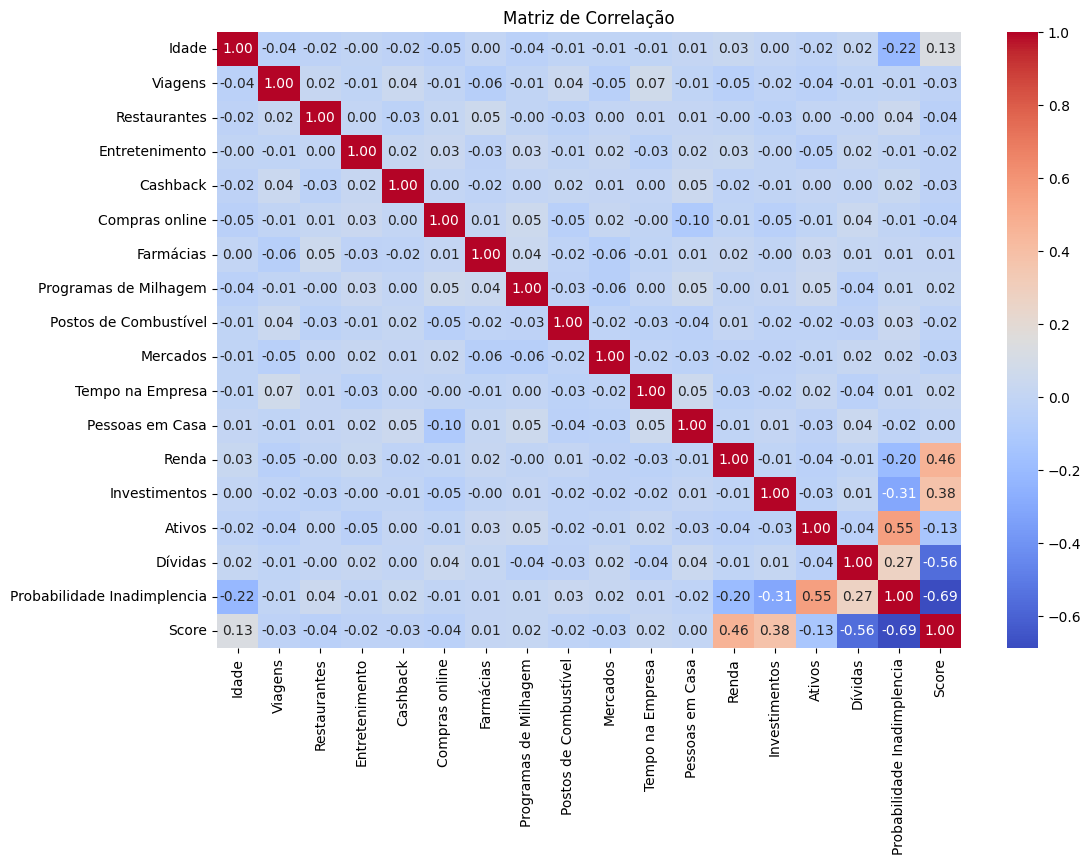

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df_clients[num_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

### Testes de Hipóteses

In [12]:
# Testes de hipóteses para variáveis categóricas (Qui - quadrado)
for cat_col in cat_vars:
  contingency_table = pd.crosstab(df_clients[cat_col], df_clients[target])
  chi2, p, dof, _ = chi2_contingency(contingency_table)
  print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
        f'Teste de Qui-Quadrado entre {cat_col} e {target}: p-valor = {p}'
        )


Teste de Qui-Quadrado entre Cidade e Probabilidade Inadimplencia: p-valor = 0.3840071939383141
Teste de Qui-Quadrado entre Cargo e Probabilidade Inadimplencia: p-valor = 0.1253795359986711
Teste de Qui-Quadrado entre Estado Civil e Probabilidade Inadimplencia: p-valor = 0.48352948196643847
Teste de Qui-Quadrado entre Moradia e Probabilidade Inadimplencia: p-valor = 0.37283145381687693
Teste de Qui-Quadrado entre Principal Cartão e Probabilidade Inadimplencia: p-valor = 1.0


### Treinar RandomForestRegressor

In [13]:
selected_features = ['Idade', 'Renda', 'Investimentos', 'Ativos', 'Dívidas']
X = df_clients[selected_features]
y = df_clients[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)

model = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f'RMSE médio na validação cruzada: {-cv_scores.mean():.2f}')

RMSE médio na validação cruzada: 6.48


### Otimização com Optuna

In [14]:
def objetive(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
  }


  model = RandomForestRegressor(**params, random_state=42)
  score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()

  return -score

study = optuna.create_study(direction='minimize')
study.optimize(objetive, n_trials=100)

best_params = study.best_params
best_metric = study.best_value
print(f'Melhores parâmetros: {best_params}')
print(f'Melhor métrica: {best_metric}')

[I 2025-04-09 13:07:51,986] A new study created in memory with name: no-name-e3abe457-05cd-4ca5-9372-5104a0ff1cfc
[I 2025-04-09 13:07:52,490] Trial 0 finished with value: 7.775933449542396 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 7.775933449542396.
[I 2025-04-09 13:07:52,719] Trial 1 finished with value: 7.564129643910334 and parameters: {'n_estimators': 70, 'max_depth': 7, 'min_samples_split': 9}. Best is trial 1 with value: 7.564129643910334.
[I 2025-04-09 13:07:53,326] Trial 2 finished with value: 7.527922639319311 and parameters: {'n_estimators': 173, 'max_depth': 9, 'min_samples_split': 10}. Best is trial 2 with value: 7.527922639319311.
[I 2025-04-09 13:07:53,765] Trial 3 finished with value: 7.763089166451102 and parameters: {'n_estimators': 134, 'max_depth': 6, 'min_samples_split': 9}. Best is trial 2 with value: 7.527922639319311.
[I 2025-04-09 13:07:54,205] Trial 4 finished with value: 7.421198339043049 and par

Melhores parâmetros: {'n_estimators': 92, 'max_depth': 10, 'min_samples_split': 2}
Melhor métrica: 6.440091158364054


### Treino e avaliação final

In [15]:
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE no conjunto e teste: {rmse:.2f}')

RMSE no conjunto e teste: 5.52


### Salvar o modelo

In [16]:
joblib.dump(best_model, 'model_default.pkl')

['model_default.pkl']

### Abrir Base Prospects

In [17]:
df_prospects = pd.read_csv('./datasets/prospects.csv')

In [18]:
df_prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID_Prospect            500 non-null    object
 1   Nome                   500 non-null    object
 2   Idade                  500 non-null    int64 
 3   Viagens                500 non-null    int64 
 4   Restaurantes           500 non-null    int64 
 5   Entretenimento         500 non-null    int64 
 6   Cashback               500 non-null    int64 
 7   Compras online         500 non-null    int64 
 8   Farmácias              500 non-null    int64 
 9   Programas de Milhagem  500 non-null    int64 
 10  Postos de Combustível  500 non-null    int64 
 11  Mercados               500 non-null    int64 
 12  Cidade                 500 non-null    object
 13  Cargo                  500 non-null    object
 14  Estado Civil           500 non-null    object
 15  Tempo na Empresa       

### Visualizar primeiros e últimos registros

In [19]:
print('Primeiros registros:')
display(df_prospects.head(10))

print('\nÚltimos registros:')
display(df_prospects.tail(10))

Primeiros registros:


,ID_Prospect,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas
0,de943fb0-5e23-4e7f-8130-1aa76b33f4dc,Francisco Fonseca,24,1,1,4,5,4,1,5,1,2,Brasília,Coach,Divorciado,14,6,Próprio,True,46006,736831,371505,88180
1,5050d0e5-5d35-4cb1-a208-596a3ee4ac1d,Melissa Mendes,58,1,4,5,3,2,3,3,1,2,São Paulo,Especialista em agronegócios,Solteiro,4,2,Próprio,False,38086,374702,1828554,31206
2,435005c0-50ea-4755-acef-b4362c08dccd,Lucca Costa,18,2,4,1,1,3,1,3,2,2,Campo Grande,Cobaia Médica,Divorciado,20,6,Próprio,False,42531,933858,1295274,178144
3,4e9951b4-1790-484c-ab25-189aa9089241,Francisco da Luz,20,4,3,1,4,1,4,2,2,4,Manaus,Classificador contábil,Solteiro,11,6,Próprio,True,16112,698799,1574952,434757
4,cb434840-2bf0-4516-8a79-8c9ada489c03,Sr. Vinícius Costela,22,1,1,4,3,5,2,3,1,2,Goiânia,Sapateiro,Solteiro,0,3,Próprio,True,3059,920950,449866,224609
5,cbadf676-7690-4837-891d-9f9d7eb20d95,Emanuelly da Mota,20,5,5,3,1,1,5,3,5,1,Porto Alegre,Paginador,Divorciado,19,5,Alugado,False,23682,796881,1572953,127732
6,2b07d568-893c-4199-8927-b47ce77afeef,Arthur Gabriel da Cruz,76,3,5,3,2,1,3,4,1,1,São Paulo,Digitador,Viúvo,15,5,Alugado,True,27069,598939,898573,494353
7,ca81a1c4-9cc5-4519-a781-8bc6509a6e39,Benicio Barbosa,76,5,1,1,5,4,4,4,3,1,Florianópolis,Metalúrgico,Casado,15,5,Próprio,True,47966,932984,456768,347189
8,c2fa002d-97ca-4abf-b473-098651f7dd58,Danilo Novaes,30,5,3,3,5,3,2,1,1,4,Fortaleza,Engenheiro florestal,Viúvo,12,2,Próprio,False,1527,228554,336970,331813
9,f7a15aaf-9b2c-4094-abb7-d7882b9054e0,Rebeca Aragão,40,1,1,4,2,4,3,3,2,4,Belo Horizonte,Lixeiro/Coletor de lixo,Divorciado,3,4,Próprio,True,39149,64118,1316458,97921



Últimos registros:


,ID_Prospect,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas
490,3a6575d6-bdee-46d8-b0a2-23e19f85d7f3,Elisa Silveira,49,1,4,3,3,5,5,1,3,2,São Paulo,Engenheiro de processos,Divorciado,8,3,Alugado,True,12637,6163,274584,406907
491,efc6cef1-74fe-4a65-867b-9a8840730c64,Dr. Brayan Leão,59,4,5,2,5,4,5,5,1,2,Goiânia,Pintor,Divorciado,20,3,Alugado,True,39957,331568,1054865,209592
492,f76d8230-2f72-4161-a5ea-e97fb130c88a,Samuel Ferreira,46,4,1,2,1,3,1,5,2,3,Salvador,Petroleiro,Viúvo,11,3,Alugado,True,16734,827124,889117,284008
493,d99bc9ae-46b7-43df-83ec-5ab52e507689,Lucca Ferreira,50,1,1,1,2,5,2,4,2,1,São Paulo,Numerólogo,Divorciado,3,2,Alugado,False,25595,63026,210868,285994
494,5280d1a3-7f61-4870-bb02-9d36a5f9e43d,Sr. João Miguel Moraes,37,2,2,1,1,2,5,5,2,3,Florianópolis,Empregado doméstico,Casado,5,1,Alugado,True,45047,405521,1096751,63731
495,9f6c824b-f107-4cab-a12f-84dd3b2bd1cb,Mateus Siqueira,64,4,2,4,1,2,5,5,1,4,Porto Alegre,Capitão,Viúvo,19,1,Próprio,False,43468,509704,898442,252781
496,ffd7325a-fbcb-4f8d-9a3a-e6417b339ceb,Elisa Santos,29,1,1,1,3,2,1,3,1,1,Fortaleza,Perito criminal,Solteiro,14,1,Próprio,True,18628,587861,765846,456844
497,051fa9d2-f447-484c-a0b2-c062b224b0cf,Sr. Vinícius Leão,68,1,5,5,3,1,2,2,4,1,Recife,Jogador de golfe,Divorciado,2,1,Alugado,False,43112,318696,758764,136074
498,041df498-64ef-4a8c-9587-daf6f942c0c5,Ayla Farias,77,3,4,5,4,2,5,4,3,3,Salvador,Meeiro,Solteiro,19,2,Próprio,False,33670,82048,495614,230262
499,9dbc78a3-4dfb-4dab-a28e-6df251a55237,Catarina Almeida,46,1,5,5,4,2,4,2,5,3,Salvador,Separador,Solteiro,4,6,Próprio,False,29876,570323,458770,492807


### Mostrar estatística das variáveis numéricas

In [20]:
num_vars = df_prospects.select_dtypes(include=['number']).columns
cat_vars = df_prospects.select_dtypes(include=['object']).columns
target = 'Probabilidade Inadimplencia'
display(df_prospects[num_vars].describe().T)

,count,mean,std,min,25%,50%,75%,max
Idade,500.00000,48.13800,18.11705,18.00000,32.00000,48.00000,63.25000,80.00000
Viagens,500.00000,2.94800,1.42877,1.00000,2.00000,3.00000,4.00000,5.00000
Restaurantes,500.00000,3.12600,1.43466,1.00000,2.00000,3.00000,4.00000,5.00000
Entretenimento,500.00000,3.00600,1.43040,1.00000,2.00000,3.00000,4.00000,5.00000
Cashback,500.00000,2.91400,1.42782,1.00000,2.00000,3.00000,4.00000,5.00000
Compras online,500.00000,2.93600,1.39420,1.00000,2.00000,3.00000,4.00000,5.00000
Farmácias,500.00000,2.95800,1.36967,1.00000,2.00000,3.00000,4.00000,5.00000
Programas de Milhagem,500.00000,3.08000,1.45528,1.00000,2.00000,3.00000,4.00000,5.00000
Postos de Combustível,500.00000,2.98800,1.42967,1.00000,2.00000,3.00000,4.00000,5.00000
Mercados,500.00000,2.99200,1.41561,1.00000,2.00000,3.00000,4.00000,5.00000


### Mostrar valores possíveis para as variáveis categóricas

In [21]:
for var in cat_vars:
  print(f'\n{var}: {df_prospects[var].nunique()} valores únicos')
  print(df_prospects[var].value_counts().head(10))


ID_Prospect: 500 valores únicos
ID_Prospect
de943fb0-5e23-4e7f-8130-1aa76b33f4dc    1
761b5833-659b-4f92-91e2-19e5b4f30fda    1
5a1cf951-270b-4fe8-afd0-04b611bb10d3    1
b2413347-3ddb-40b4-9a6d-c72a1ee56f86    1
9aedf54f-494a-4158-9ce2-a0b018babb93    1
47df26ea-cee0-4f44-ac3f-cc95b868d86d    1
47494aa0-ca1d-4fb6-8bc6-156b16335e02    1
53a19af2-30b9-49fb-86c9-fff8b5f89b15    1
1c2c013e-a37a-4a3a-99ab-b4d31925265e    1
ae67c288-2379-4c36-a396-7d2d74ec1f86    1
Name: count, dtype: int64

Nome: 497 valores únicos
Nome
Caio Novais             2
Mateus Teixeira         2
Maria Duarte            2
Breno Barbosa           1
Oliver Casa Grande      1
Brayan Câmara           1
Emilly Andrade          1
Ana Luiza Cavalcanti    1
Maria Helena Novais     1
Murilo Nunes            1
Name: count, dtype: int64

Cidade: 15 valores únicos
Cidade
São Paulo         45
Florianópolis     44
Salvador          44
Manaus            42
Recife            38
Porto Alegre      36
Curitiba          35
Goiânia    

### Apresentar histograma das variáveis numéricas

In [22]:
# Numéro de colunas desejadas
num_cols = 3

# Calcular o número de linhas ncessárias
num_rows = math.ceil(len(num_vars)/ num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(num_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1

  fig.add_trace(
    go.Histogram(x=df_prospects[var], name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=300*num_rows,
  width=1200,
  title_text="Histogramas das Variáveis Numéricas",
  showlegend=False
)

fig.show()

### Gráfico de barras para variáveis categóricas

In [23]:
# Numéro de colunas desejadas
num_cols = 3

# Calcular o número de linhas ncessárias
num_rows = math.ceil(len(cat_vars)/ num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar histogramas para cada variável categórica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1

  fig.add_trace(
    go.Bar(x=df_prospects[var].value_counts().index[:10],
           y=df_prospects[var].value_counts().values[:10],
           name=var),
    row=row, col=col
  )

# Atualizar layout
# Atualizar layout para remover a legenda
fig.update_layout(
  height=500*num_rows,
  width=1200,
  title_text="Histogramas das Variáveis Categóricas",
  showlegend=False
)

fig.show()

### Carregar modelo

In [24]:
model = joblib.load('model_default.pkl')

### Preparar dados

In [25]:
selected_features = ['Idade', 'Renda', 'Investimentos', 'Ativos', 'Dívidas']
X_prospects = df_prospects[selected_features]

### Realizar predição

In [26]:
df_prospects['Probabilidade Inadimplencia'] = model.predict(X_prospects)
df_prospects['Probabilidade Inadimplencia'] = round(df_prospects['Probabilidade Inadimplencia'], 2)

### Calcular score

In [27]:
def calc_score(row):
  norm_income = min(row['Renda'] / 50000, 1)
  norm_investment = min(row['Investimentos'] / 1e6, 1)
  norm_asset = min(row['Ativos'] / 2e6, 1)
  norm_debt = min(row['Dívidas'] / 5e5, 1)

  base_score = (norm_income*0.4 + norm_investment*0.3 + norm_asset*0.2 + norm_debt*0.4) * 1000
  adjusted_score = base_score * (1 - (row['Probabilidade Inadimplencia'] / 100))

  return int(round(max(0, min(1000, adjusted_score))))

df_prospects['Score'] = df_prospects.apply(calc_score, axis=1)

### Salvar resultados

In [28]:
df_prospects.to_csv('./datasets/prospects_with_score.csv', index=False)